In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 
import keras_tuner as kt

# Import Data

In [2]:
df = pd.read_csv('./train.csv')
df.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


In [3]:
df.shape

(6525, 3)

In [4]:
df.rename({'Label': 'label', 'TweetText':'tweet'}, axis=1, inplace=True)
df.drop(columns=['TweetId'], axis=1, inplace=True)

In [5]:
df.head()

,label,tweet
0,Politics,'#SecKerry: The value of the @StateDept and @U...
1,Politics,'@rraina1481 I fear so'
2,Sports,'Watch video highlights of the #wwc13 final be...
3,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,Sports,'@cricketfox Always a good thing. Thanks for t...


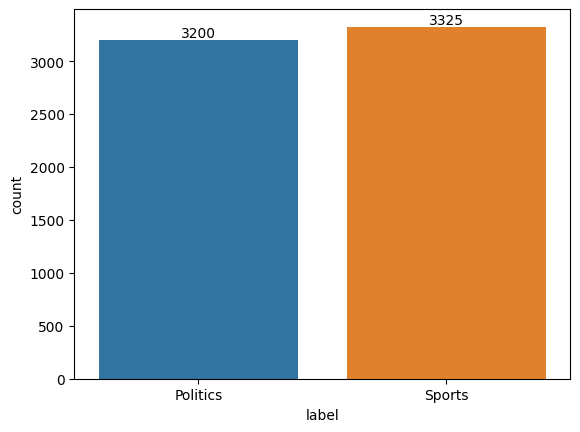

In [6]:
plot1 = sns.countplot(df, x='label')
for container in plot1.containers:
    plot1.bar_label(container)

the dataset is pretty balance so we can use accuracy as an evaluation metric

In [7]:
df.isna().sum()

label    0
tweet    0
dtype: int64

# Data Preprocessing

In [8]:
stemmer = PorterStemmer()
stop_words = nltk.corpus.stopwords.words('english')
def preprocess_text(text, 
                    remove_single_char=True, 
                    tokenize=True, 
                    stemming=True, 
                    remove_stop_words=True):
    
    # remove unicode and quotes on both ends
    text = text.encode().decode('unicode-escape').strip('\'"')
    
    # remove urls
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+', ' ', text)
    
    # remove non-alphanumeric values
    text = re.sub(r'\W', ' ', text)
    
    # remove single characters
    if remove_single_char:
        text = re.sub(r'\s+[a-zA-z]\s+', ' ', text)
        
    # remove number
    text = re.sub(r'\d+', '', text)
        
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    # lower case
    text = text.lower().strip()
    
    # tokenize text
    if tokenize:
        text = nltk.word_tokenize(text)
    
    # remove stop words
    if remove_stop_words:
        if isinstance(text, list):
            text = [word for word in text if word not in stop_words]
        else:
            text = " ".join([word for word in text.split() if word not in stop_words])
    
    # stemming
    if stemming:
        if isinstance(text, list):
            text = " ".join([stemmer.stem(token) for token in text])
        else:
            text = " ".join([stemmer.stem(word) for word in text.split()])
    
    return text

In [9]:
df['cleaned_text'] = df['tweet'].apply(preprocess_text)

X = pd.DataFrame(df['cleaned_text'])
y = df['label']

## WordCloud

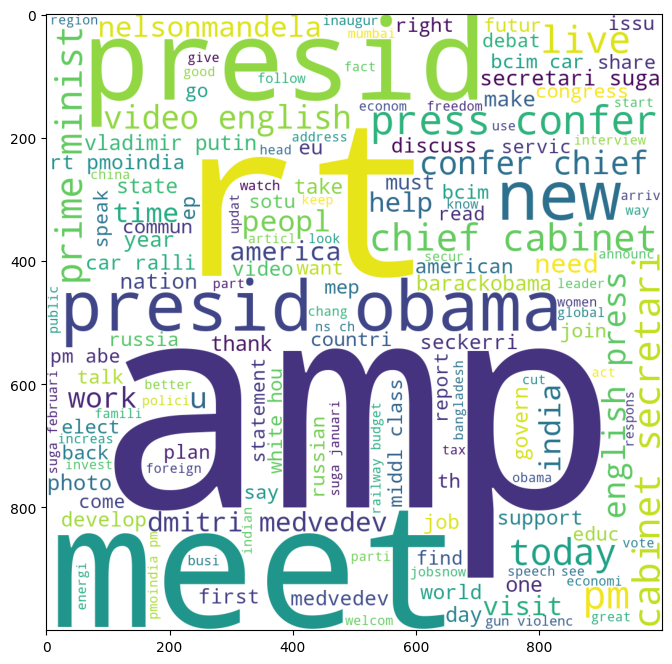

In [102]:
wc = WordCloud(width=1000, height=1000, background_color='white', min_font_size=15)
wc_politics = wc.generate(df[df.label == "Politics"]['cleaned_text'].str.cat(sep=' '))
plt.figure(figsize=(8,8))
plt.imshow(wc_politics)

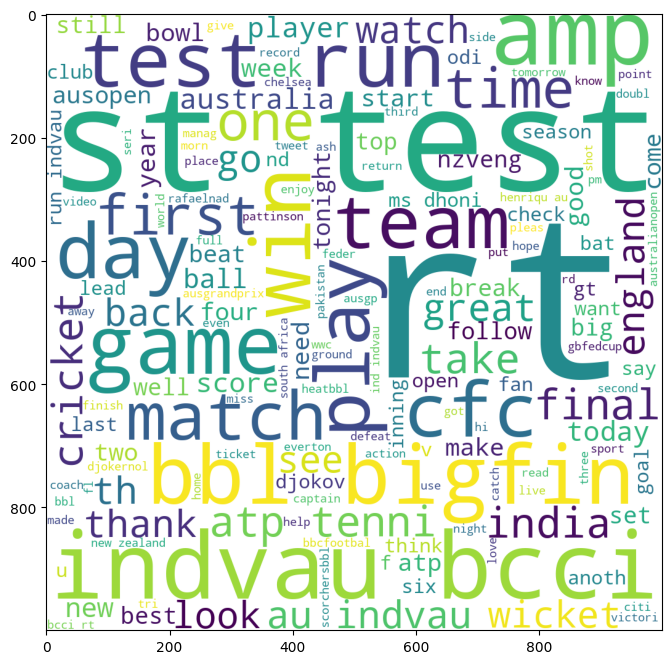

In [103]:
wc = WordCloud(width=1000, height=1000, background_color='white', min_font_size=15)
wc_sports = wc.generate(df[df.label == "Sports"]['cleaned_text'].str.cat(sep=' '))
plt.figure(figsize=(8,8))
plt.imshow(wc_sports)

# Feature Extraction

In [104]:
def generate_data(vectorizer, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = vectorizer.fit_transform(X_train['cleaned_text']).toarray()
    X_test = vectorizer.transform(X_test['cleaned_text']).toarray()
    return X_train, X_test, y_train, y_test

In [105]:
vectorizer1 = TfidfVectorizer(max_features=10000)
X_train, X_test, y_train, y_test = generate_data(vectorizer1, X, y)

# Model Selection

In [108]:
def test_models(X_train, X_test, y_train, y_test):

    models = {
        "Logistic Regression": LogisticRegression(),
        "GNB": GaussianNB(),
        "BNB": BernoulliNB(),
        "MNB": MultinomialNB(),
#       "KNN": KNeighborsClassifier(),
#       "lightgbm": LGBMClassifier(),
#       "XGBoost": XGBClassifier(),
      "Random Forest": RandomForestClassifier(),
      'Decision Tree': DecisionTreeClassifier(),
    }
    models_performance = {"model":[], "training_accuracy":[], "testing_accuracy":[], "training_time":[]}
    for key, model in models.items():
        print(f"model: {key}")
        models_performance['model'].append(key)
        
        start = time.time()
        model.fit(X_train, y_train)
        stop = time.time()
        training_time = stop - start
        models_performance['training_time'].append(training_time)
        
        # Training Accuracy
        y_train_pred = model.predict(X_train)
        training_accuracy = accuracy_score(y_train, y_train_pred)
        models_performance['training_accuracy'].append(training_accuracy)
        
        # Testing Accuracy
        y_test_pred = model.predict(X_test)
        testing_accuracy = accuracy_score(y_test, y_test_pred)
        models_performance['testing_accuracy'].append(testing_accuracy)
        
    return pd.DataFrame(models_performance)

In [109]:
models_performance = test_models(X_train, X_test, y_train, y_test)
models_performance

model: Logistic Regression
model: GNB
model: BNB
model: MNB
model: Random Forest
model: Decision Tree


,model,training_accuracy,testing_accuracy,training_time
0,Logistic Regression,0.986207,0.957854,1.988721
1,GNB,0.998467,0.936398,0.789900
2,BNB,0.982184,0.963985,0.377522
3,MNB,0.985441,0.963218,0.117687
4,Random Forest,1.000000,0.926437,28.553573
5,Decision Tree,1.000000,0.891188,20.684208


## Feature Importance

since not every feature generated by Tfidf vectorizer relevant to our classification we'll try to filter only the important features using chi-squared test and see if there'll be any improvement in the performance

In [110]:
feature_names = vectorizer1.get_feature_names_out()
confidence_level = 0.95

_, p_value = chi2(X_train, y_train)
feature_importance = pd.DataFrame({"feature":feature_names, "score":1-p_value})
feature_importance = feature_importance[feature_importance["score"]>=confidence_level]

important_features = feature_importance['feature'].unique()

In [111]:
vectorizer2 = TfidfVectorizer(max_features=10000, vocabulary=important_features)
X_train, X_test, y_train, y_test = generate_data(vectorizer2, X, y)

In [112]:
models_performance = test_models(X_train, X_test, y_train, y_test)
models_performance

model: Logistic Regression
model: GNB
model: BNB
model: MNB
model: Random Forest
model: Decision Tree


,model,training_accuracy,testing_accuracy,training_time
0,Logistic Regression,0.927586,0.926437,0.131649
1,GNB,0.918966,0.914943,0.059841
2,BNB,0.924713,0.924904,0.026959
3,MNB,0.925862,0.928736,0.012938
4,Random Forest,0.943103,0.900383,2.788981
5,Decision Tree,0.943103,0.885057,0.522591


In [113]:
X_train.shape

(5220, 402)

as you can see we went from 10k feature to only 397 feature but had a performance downgrade we'll stick to 10k feature

## Hyperparameter tuning

In [114]:
tfidf = TfidfVectorizer(max_features=10000)
X_train, X_test, y_train, y_test = generate_data(tfidf, X, y)

In [115]:
models = {
    "Logistic Regression": LogisticRegression(),
    "BNB": BernoulliNB(),
    "MNB": MultinomialNB()
}

param_grids = {
    "Logistic Regression": {'C': [0.001, 0.01, 0.1]},
    "BNB": {'alpha': [0.1, 0.5, 1, 1.5, 2]},
    "MNB": {'alpha': [0.1, 0.5, 1, 1.5, 2]}
}

In [116]:
scores = pd.DataFrame({'Model': models.keys(), 'Accuracy': np.zeros(len(models))})
model_best_params = models.copy()
i = 0
for key, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[key], cv=4, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    scores.iloc[i, 1] = grid_search.score(X_test, y_test)
    
    model_best_params[key] = grid_search.best_params_
    i += 1

In [117]:
scores

,Model,Accuracy
0,Logistic Regression,0.941762
1,BNB,0.970881
2,MNB,0.968582


In [118]:
model_best_params

{'Logistic Regression': {'C': 0.1},
 'BNB': {'alpha': 0.1},
 'MNB': {'alpha': 0.1}}

## Deep Learning Models

### Word Embedding + Basic NN network

using google nnlm-en-dim50 word embedding

In [10]:
tf_ds = pd.concat([
                    df.tweet.apply(lambda x: preprocess_text(x, tokenize=False,stemming=False, remove_stop_words=True)), 
                    pd.DataFrame(np.where(df.label=="Politics", 1, 0), columns=['label'])
                  ], 
                  axis=1)

In [11]:
train, val, test = np.split(tf_ds.sample(frac=1), [int(0.8*len(tf_ds)), int(0.9*len(tf_ds))])

change pandas dataframe to tensorflow dataset as it's much faster to process

In [12]:
def df_to_dataset(dataframe, shuffle=True, batch_size=256,x_col='tweet', y_col='label'):
    df = dataframe.copy()
    labels = df.pop(y_col)
    df = df[x_col]
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [13]:
train = df_to_dataset(train)
test = df_to_dataset(test)
val = df_to_dataset(val)

In [14]:
hub_url = 'https://tfhub.dev/google/nnlm-en-dim50/2'
embedding_hub_layer = hub.KerasLayer(hub_url, dtype=tf.string, trainable=True)

In [15]:
model = tf.keras.Sequential()
model.add(embedding_hub_layer)
model.add(layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [18]:
history = model.fit(train, epochs=10, validation_data=val, callbacks=[early_stopping])

Epoch 1/10
21/21 [==============================] - 4s 75ms/step - loss: 0.6984 - accuracy: 0.6044 - val_loss: 0.6549 - val_accuracy: 0.7868
Epoch 2/10
21/21 [==============================] - 1s 56ms/step - loss: 0.6360 - accuracy: 0.6944 - val_loss: 0.5724 - val_accuracy: 0.8528
Epoch 3/10
21/21 [==============================] - 1s 58ms/step - loss: 0.5538 - accuracy: 0.7870 - val_loss: 0.4701 - val_accuracy: 0.9110
Epoch 4/10
21/21 [==============================] - 1s 57ms/step - loss: 0.4685 - accuracy: 0.8339 - val_loss: 0.3647 - val_accuracy: 0.9279
Epoch 5/10
21/21 [==============================] - 1s 57ms/step - loss: 0.3862 - accuracy: 0.8843 - val_loss: 0.2777 - val_accuracy: 0.9387
Epoch 6/10
21/21 [==============================] - 1s 57ms/step - loss: 0.3183 - accuracy: 0.9096 - val_loss: 0.2200 - val_accuracy: 0.9433
Epoch 7/10
21/21 [==============================] - 1s 59ms/step - loss: 0.2631 - accuracy: 0.9291 - val_loss: 0.1867 - val_accuracy: 0.9509
Epoch 8/10
21

In [19]:
model.evaluate(test)

3/3 [==============================] - 0s 4ms/step - loss: 0.1916 - accuracy: 0.9342


[0.1916445791721344, 0.9341500997543335]

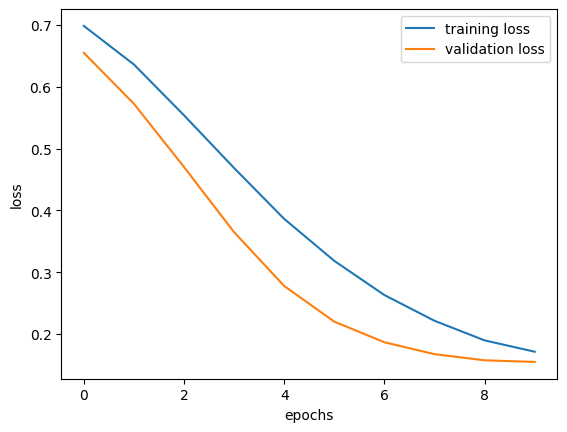

In [20]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [22]:
test_df = pd.read_csv('./test.csv')
test_df['tweet'] = test_df['TweetText'].apply(preprocess_text)

In [31]:
labels = model.predict(tf.constant(test_df['tweet']))
labels

82/82 [==============================] - 0s 2ms/step


array([[0.01346837],
       [0.31097147],
       [0.9374527 ],
       ...,
       [0.03050299],
       [0.8802048 ],
       [0.6149707 ]], dtype=float32)

In [32]:
mask = labels > 0.5
labels = np.where(mask, 'Politics', 'Sports')
labels

array([['Sports'],
       ['Sports'],
       ['Politics'],
       ...,
       ['Sports'],
       ['Politics'],
       ['Politics']], dtype='<U8')

In [33]:
test_df

,TweetId,TweetText,tweet
0,306486520121012224,'28. The home side threaten again through Maso...,home side threaten mason bennett get end long ...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....,mrbrown aulia thx ask see deriv seri abbrevi p...
2,289531046037438464,'@Sochi2014 construction along the shores of t...,sochi construct along shore black sea
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...,seckerri remark meet foreign minist westerwel ...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...,iplauct begun ricki pont first player go hamme...
...,...,...,...
2605,282023761044189184,'Qualifier 1 and Eliminator games will be play...,qualifi elimin game play chidambaram stadium h...
2606,303879735006601216,"@reesedward Hi Edward, it's not a #peacekeepin...",reesedward hi edward peacekeep mission guineab...
2607,297956846046703616,'Perera was @SunRisersIPL first #IPL purchase ...,perera sunrisersipl first ipl purchas iplauct
2608,304265049537658880,"'#SecKerry: Thanks to Senator @TimKaine, @RepR...",seckerri thank senat timkain reproberthurt uva...


In [37]:
len(labels)

2610

In [41]:
test_df['TweetId'].to_list().shape

AttributeError: 'list' object has no attribute 'shape'

In [44]:
labels.reshape()

array([['Sports'],
       ['Sports'],
       ['Politics'],
       ...,
       ['Sports'],
       ['Politics'],
       ['Politics']], dtype='<U8')

In [39]:
pd.DataFrame({'TweetId':test_df['TweetId'].to_list(), 'Label':labels}, columns=['TweetId', 'Label'])

ValueError: Per-column arrays must each be 1-dimensional

Basic NN don't seem to be a good model for sequence input data knowing we have overfitting in this case we'll try better architecture

## LSTM

In [130]:
tf_ds = pd.concat([
                    df.tweet.apply(lambda x: preprocess_text(x, tokenize=False)), 
                    pd.DataFrame(np.where(df.label=="Politics", 1, 0), columns=['label'])
                  ], 
                  axis=1)

In [131]:
train, val, test = np.split(tf_ds.sample(frac=1), [int(0.8*len(tf_ds)), int(0.9*len(tf_ds))])

In [132]:
train = df_to_dataset(train)
test = df_to_dataset(test)
val = df_to_dataset(val)

In [133]:
encoder = layers.TextVectorization(max_tokens=5000)
encoder.adapt(train.map(lambda text, label: text))

In [134]:
encoder.get_vocabulary()[:10]

['', '[UNK]', 'rt', 'amp', 'test', 'presid', 'indvau', 'pm', 'obama', 'run']

### LSTM Hyperparameter tuning

In [135]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(encoder)
    model.add(layers.Embedding(
                            input_dim=len(encoder.get_vocabulary()),
                            output_dim=32,
                            mask_zero=True
                              )
             )
    
    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_lstm_layer = hp.Int('lstm_layer', min_value=4, max_value=32, step=2)
    hp_dense_layer = hp.Int('dense_layer', min_value=4, max_value=32, step=2)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_dropout_rate = hp.Choice('dropout_rate', values=[0.3, 0.4])
    
    model.add(layers.LSTM(units=hp_lstm_layer))
    model.add(layers.Dense(units=hp_dense_layer, activation=hp_activation))
    model.add(layers.Dropout(hp_dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

In [136]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='x')

Reloading Tuner from dir\x\tuner0.json


In [137]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [138]:
tuner.search(train, epochs=20, validation_data=val, callbacks=[early_stopping])

In [139]:
best_hyper_parameters = tuner.get_best_hyperparameters()[0]

In [140]:
model = tuner.hypermodel.build(best_hyper_parameters)
history = model.fit(train, epochs=50, validation_data=val, callbacks=[early_stopping])

Epoch 1/50
21/21 [==============================] - 5s 72ms/step - loss: 0.4263 - accuracy: 0.7929 - val_loss: 0.1598 - val_accuracy: 0.9356
Epoch 2/50
21/21 [==============================] - 0s 15ms/step - loss: 0.1027 - accuracy: 0.9738 - val_loss: 0.1601 - val_accuracy: 0.9463
Epoch 3/50
21/21 [==============================] - 0s 13ms/step - loss: 0.0401 - accuracy: 0.9893 - val_loss: 0.2093 - val_accuracy: 0.9463
Epoch 4/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.2813 - val_accuracy: 0.9387


In [141]:
model.evaluate(test)

3/3 [==============================] - 0s 6ms/step - loss: 0.1602 - accuracy: 0.9296


[0.16017460823059082, 0.9295558929443359]

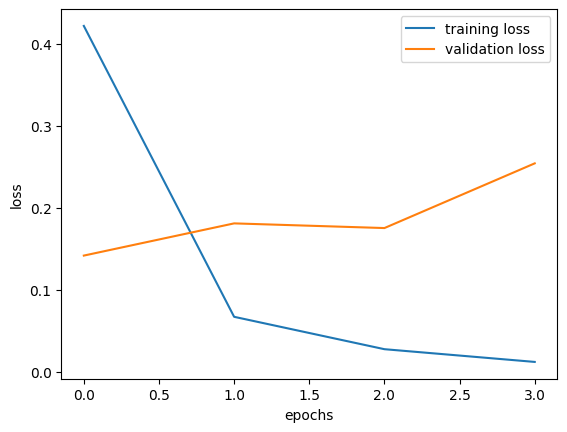

In [53]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

Obviously we have an overfitting problem but because of tuner and early stopping we managed to get the best results, but after testing different models the BNB & MNB still perform better so we'll pick BNB for this classification task

## BEST MODEL + Submition

In [215]:
tfidf = TfidfVectorizer(max_features=10000)
# training data
X_train = df['cleaned_text']
y_train = df['label']
X_train = tfidf.fit_transform(X_train).toarray()

# test submission data
X_test = pd.read_csv('./test.csv')
submission = X_test[['TweetId']]

# preprocessing
X_test = X_test['TweetText'].apply(preprocess_text)
X_test = tfidf.transform(X_test).toarray()

In [216]:
model = BernoulliNB(**model_best_params['BNB'])
model.fit(X_train, y_train)

BernoulliNB(alpha=0.1)

In [217]:
predictions = model.predict(X_test)

In [218]:
submission['Label'] = predictions

In [219]:
submission.head()

,TweetId,Label
0,306486520121012224,Sports
1,286353402605228032,Sports
2,289531046037438464,Politics
3,306451661403062273,Politics
4,297941800658812928,Sports


In [220]:
submission.to_csv('submissions.csv', index=False, index_label=False)

# Other Approaches

there many things we could do that maybe will result in better performace such as:

**Use different word embedding**: there is plenty of word embeddings we can use for this task for example Word2Vec or bert word embedding

**Preprocessing**: we can't of course try all the possible pre processing techniques, we used previously stemming we could use lemmization instead or take advantage of ngrams in tfidf vectorizer 

**Evaluation Metrics**: we can benefit from ROC-AUC metrics especially for the deep learning models that we used before to help us make a good decision for the threshold 

**LLM**: in this era of llm models we could easily fine tune a large language model as they're trained on billions of data 

In [6]:
train = pd.read_csv('./train.csv')
train

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...
...,...,...,...
6520,296675082267410433,Politics,'Photo: PM has laid a wreath at Martyrs Monume...
6521,306677536195231746,Sports,'The secret of the Chennai pitch - crumbling o...
6522,306451295307431937,Sports,@alinabhutto he isn't on Twitter either
6523,306088574221176832,Sports,'Which England player would you take out to di...


In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [8]:
def process_data(row):

    text = row['TweetText']
    text = str(text)
    text = ' '.join(text.split())

    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=128)

    label = 0
    if row['Label'] == 'Politics':
        label += 1

    encodings['label'] = label
    encodings['tweettext'] = text

    return encodings

In [9]:
processed_data = []

for i in range(len(train)):
    processed_data.append(process_data(train.iloc[i]))

In [10]:
from sklearn.model_selection import train_test_split

new_df = pd.DataFrame(processed_data)

train_df, valid_df = train_test_split(
    new_df,
    test_size=0.2,
    random_state=2022
)

In [11]:
import pyarrow as pa
from datasets import Dataset

train_hg = Dataset(pa.Table.from_pandas(train_df))
valid_hg = Dataset(pa.Table.from_pandas(valid_df))

In [12]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="./result")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hg,
    eval_dataset=valid_hg,
    tokenizer=tokenizer
)

In [14]:
trainer.train()

Step,Training Loss
500,0.229600
1000,0.102500
1500,0.048900


Checkpoint destination directory ./result\checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1959, training_loss=0.09950314132822843, metrics={'train_runtime': 605.8506, 'train_samples_per_second': 25.848, 'train_steps_per_second': 3.233, 'total_flos': 1030079781734400.0, 'train_loss': 0.09950314132822843, 'epoch': 3.0})

In [15]:
model.save_pretrained('./model/')

In [16]:
from transformers import AutoModelForSequenceClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

new_model = AutoModelForSequenceClassification.from_pretrained('./model/').to(device)

In [17]:
from transformers import AutoTokenizer

new_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [26]:
import torch
import numpy as np

def get_prediction(text):
    encoding = new_tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

    outputs = new_model(**encoding)

    logits = outputs.logits
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sigmoid = torch.nn.Sigmoid()
    print(sigmoid)
    probs = sigmoid(logits.squeeze().cpu())
    probs = probs.detach().numpy()
    label = np.argmax(probs, axis=-1)
    
    if label == 1:
        return 'Politics'
    else:
        return 'Sports'

In [24]:
test = pd.read_csv('./test.csv')
test

,TweetId,TweetText
0,306486520121012224,'28. The home side threaten again through Maso...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....
2,289531046037438464,'@Sochi2014 construction along the shores of t...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...
...,...,...
2605,282023761044189184,'Qualifier 1 and Eliminator games will be play...
2606,303879735006601216,"@reesedward Hi Edward, it's not a #peacekeepin..."
2607,297956846046703616,'Perera was @SunRisersIPL first #IPL purchase ...
2608,304265049537658880,"'#SecKerry: Thanks to Senator @TimKaine, @RepR..."


In [28]:
test['Label'] = test['TweetText'].apply(get_prediction)

Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()


Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()


Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()


Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()
Sigmoid()


In [30]:
test.drop(columns=['TweetText'], axis=1).to_csv('submission_bert.csv', index=False, index_label=False)